In [1]:
from IPython.core.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from collections import defaultdict
import traceback
import numpy as np
import scipy.stats as ss
import yaml
import itertools
import sys
import os
import subprocess
from os import path
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

def printmd(*args):
    display(Markdown(' '.join(map(str, args))))

In [2]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning/*" -s

In [3]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning_gen_circles/*" -s

In [4]:
local_planner_color = {'dwb': 'blue', 'rpp': 'orange', 'teb': 'green'}
robot_model_color = {'hunter': 'cyan', 'turtle': 'green'}
pd.options.display.width = 500
pd.options.display.max_rows = 0
pd.options.display.float_format = '{:,.3f}'.format
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['lines.linewidth'] = 2
# plt.rcParams['lines.markersize'] = 3
# plt.rcParams['lines.marker'] = 'o'

# fg_color = 'white'
# plt.rcParams['grid.color'] = 'gray'
# plt.rcParams['text.color'] = fg_color
# plt.rcParams['ytick.color'] = fg_color
# plt.rcParams['xtick.color'] = fg_color
# plt.rcParams['axes.labelcolor'] = fg_color
# plt.rcParams['axes.edgecolor'] = fg_color

# bg_color = "#323a48"
# plt.rcParams['figure.facecolor'] = bg_color
# plt.rcParams['axes.facecolor'] = bg_color
# plt.rcParams['legend.facecolor'] = bg_color

In [5]:
df = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results.csv"))
with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results_info.yaml")) as results_info_file:
    results_info = yaml.safe_load(results_info_file)

# df_real = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results.csv"))
# with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results_info.yaml")) as results_real_info_file:
#     results_real_info = yaml.safe_load(results_real_info_file)
# df_real = df_real[(df_real.amcl_alpha_factor.notna()) & (df_real.robot_model=='turtlebot3_waffle_performance_modelling')]
# 
# df_gen = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning_gen_circles/results.csv"))
# with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning_gen_circles/results_info.yaml")) as results_gen_info_file:
#     results_gen_info = yaml.safe_load(results_gen_info_file)

# df = df_gen.append(df_real, sort=True)

df.rename(inplace=True, columns={
    'collisionless_localization_update_absolute_translation_error_mean': 'absolute_translation_error',
    'collisionless_localization_update_absolute_rotation_error_mean': 'absolute_rotation_error',
    'collisionless_localization_update_normalized_relative_translation_error_mean': 'normalized_relative_translation_error',
    'collisionless_localization_update_normalized_relative_rotation_error_mean': 'normalized_relative_rotation_error',
    'localization_update_rate_mean': 'localization_update_rate',
})

# results_info = results_gen_info
# results_info['run_parameter_names'] += [i for i in results_real_info['run_parameter_names'] if i not in results_info['run_parameter_names']]

# TEMP: only consider real localization
# df = df[df.localization_node != 'localization_generator']
# df = df[(df.amcl_alpha_factor == 1.0) | (df.amcl_alpha_factor == 0.0)]

df.fixed_rpp = df.fixed_rpp.fillna(False)
df.loc[(df.fixed_rpp == False) & (df.local_planner_node == 'rpp'), 'local_planner_node'] = 'rpp_bad'
df = df[df.local_planner_node != 'rpp_bad'].copy()

# df = df[df.amcl_alpha_factor.notna()]

# turn odometry_error into beta_1..4
results_info['run_parameter_names'] += ['beta_1', 'beta_2', 'beta_3', 'beta_4']
results_info['run_parameter_names'].remove('odometry_error')
for i in range(0, 4):
    df[f'beta_{i+1}'] = df['odometry_error'].apply(lambda x: eval(x)[i])
del df['odometry_error']

df.loc[df.robot_model == 'turtlebot3_waffle_performance_modelling', 'robot_model'] = 'turtle'
df.loc[df.robot_model == 'hunter2', 'robot_model'] = 'hunter'

run_parameters = [c for c in list(df.columns) if c in results_info['run_parameter_names']]
metrics_versions = [c for c in list(df.columns) if '_version' in c]
everything_else = ['run_id', 'session_id', 'run_number']
metrics = [c for c in df.columns if c not in metrics_versions + run_parameters + everything_else]
metrics_and_versions = [c for c in list(df.columns) if '_version' in c or c in metrics]

cpu_time_metrics = [c for c in metrics if 'cpu_time' in c]
max_memory_metrics = [c for c in metrics if 'max_memory' in c]

# add useful parameters
df['session_id'] =  df['run_id'].apply(lambda x:  x.split('_')[1]+'_'+x.split('_')[2]+'_'+x.split('_')[3])
df['run_number'] =  df['run_id'].apply(lambda x:  int(x.split('_')[5]))
df[max_memory_metrics] = df[max_memory_metrics]/1024**2
df.max_steering_angle_deg = df.max_steering_angle_deg.fillna(90)

# add metrics from existing ones
df['average_velocity'] = df['trajectory_length'] / df['execution_time']
df['collisionless_success_rate'] = df['success_rate'] & (1 - df['collision_rate'])
metrics += ['average_velocity', 'collisionless_success_rate']
metrics_and_versions += ['average_velocity', 'collisionless_success_rate']

# add aggregated data
min_trajectory_length_group_df = df.groupby(["environment_name", "run_index", "collisionless_success_rate"])
for (environment_name, run_index, collisionless_success_rate), group_df in min_trajectory_length_group_df:
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (collisionless_success_rate), 'min_trajectory_length'] = group_df.trajectory_length.min()
df['norm_trajectory_length'] = df.trajectory_length / df.min_trajectory_length
metrics += ['norm_trajectory_length']
metrics_and_versions += ['norm_trajectory_length']

min_execution_time_group_df = df.groupby(["environment_name", "run_index", "collisionless_success_rate"])
for (environment_name, run_index, collisionless_success_rate), group_df in min_execution_time_group_df:
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (collisionless_success_rate), 'min_execution_time'] = group_df.execution_time.min()
df['norm_execution_time'] = df.execution_time / df.min_execution_time
metrics += ['norm_execution_time']
metrics_and_versions += ['norm_execution_time']

if False:
# if True:
    printmd("## Number of Runs")
    printmd(f"    {len(df.run_id.unique())}")

    printmd("## Run Parameters")
    for name in [run_parameter_name for run_parameter_name in run_parameters if 'localization_generator_' not in run_parameter_name]:
        values = list(df[name].unique())
        printmd(f"    {name:<70}", sorted(values))

    printmd("## Metrics")
    for name in metrics_and_versions:
        if name in metrics_versions:
            if len(df[name].unique()) == 1:
                printmd(f"    {name:<70} {sorted(df[name].unique())}")
            else:
                printmd(f"<code><font style='background-color:yellow;font-family:monospace'>{name:<70}{sorted(df[name].unique())} </font></code> ⚠️")
        else:
            printmd(f"    {name:<70} min: {df[name].min(skipna=True):10.4g} {'avg':>15}: {df[name].mean(skipna=True):10.4g} {'max':>15}: {df[name].max(skipna=True):10.4g} {'nan':>15}: {sum(df[name].isna()):10.4g}")

### in:

localization_node = amcl                                               num feature datapoints: 5034
local_planner_node = dwb                                               num feature datapoints: 944
global_planner_node = navfn                                            num feature datapoints: 3520
amcl_alpha_factor = 1.0                                                num feature datapoints: 1329
beta_1 = 0.02                                                          num feature datapoints: 1571
robot_model = turtle                                                   num feature datapoints: 4280
max_steering_angle_deg = 90.0                                          num feature datapoints: 3522


### out:

num datapoints: 97
absolute_translation_error                                             min: 0.00924 mean: 0.05273 max: 0.13287 std: 0.02254


/usr/lib/python3/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/lib/python3/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


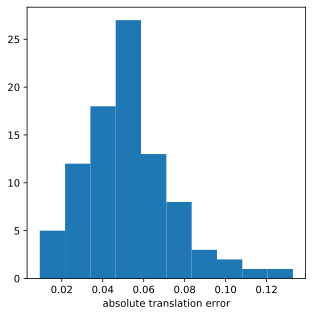

absolute_rotation_error                                                min: 0.00192 mean: 0.00992 max: 0.06332 std: 0.00814


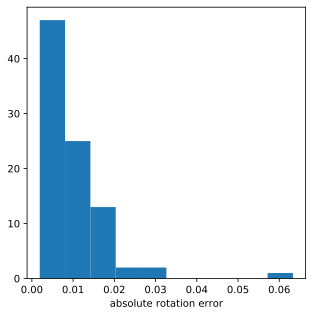

normalized_relative_translation_error                                  min: 0.01250 mean: 0.03027 max: 0.08930 std: 0.01361


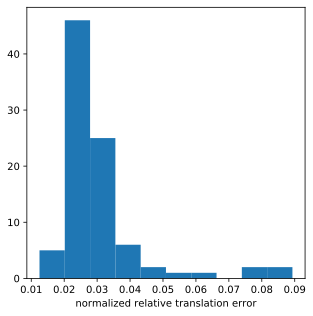

normalized_relative_rotation_error                                     min: 0.00932 mean: 0.09104 max: 1.33471 std: 0.25603


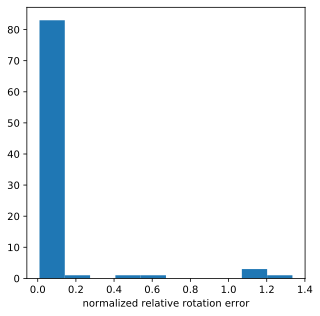

In [13]:

localization_input_target_components = [
    'localization_node',
    'local_planner_node',
    'global_planner_node',
]
localization_input_component_features = [
    'amcl_alpha_factor',
]
localization_input_system_features = [
    'beta_1',
    'robot_model',
    'max_steering_angle_deg',
]
localization_input_performance_features = [
    'average_translation_velocity',
    'average_velocity_atan',
]

localization_output = [
    'absolute_translation_error',
    'absolute_rotation_error',
    'normalized_relative_translation_error',
    'normalized_relative_rotation_error',
]

import copy
class FeatureSelection:
    def __init__(self, name, value, window, is_discrete):
        self.name = name
        self.value = value
        self.window = window
        self.is_discrete = is_discrete
    def __str__(self):
        return f"{self.name} = {self.value}" + (f" ± {self.window}" if self.window is not None else "")
    def get_range(self):
        return [self.value - self.window, self.value + self.window] if self.window is not None else [self.value, self.value]
    def with_value(self, value):
        ret = copy.deepcopy(self)
        ret.value = value
        return ret

def select_data(d, features_in):
    df_select = d
    for f in features_in:
        df_select = df_select[df_select[f.name].between(*f.get_range())]
    return df_select

def plot_predictions_1(d, output, feature_1, fixed_features, n1=20, min_y=None, max_y=None, print_count_and_stuff=False):

    fig = plt.figure()


    x1_ls = np.linspace(d[feature_1.name].min() + feature_1.window, d[feature_1.name].max() - feature_1.window, n1) if not feature_1.is_discrete else sorted(d[feature_1.name].unique())

    y_ds = list(map(lambda x1: select_data(d, fixed_features + [feature_1.with_value(x1)])[output], x1_ls))
    y_mean = list(map(lambda y_ds_i: y_ds_i.mean(), y_ds))

    if print_count_and_stuff:
        print()
        count_and_stuff_ds = pd.DataFrame({
        'x1_ls': x1_ls,
        'y_mean': y_mean,
        'y_std': list(map(lambda y_ds_i: y_ds_i.std(), y_ds)),
        'y_count': list(map(lambda y_ds_i: y_ds_i.count(), y_ds)),
        })
        print(count_and_stuff_ds)    
    
    d_scatter_1 = select_data(d, fixed_features)
    plt.scatter(d_scatter_1[feature_1.name], d_scatter_1[output], color='gray')
#     print(f"feature_1: {feature_1}")
    d_scatter_2 = select_data(d, fixed_features + [feature_1])
    plt.scatter(d_scatter_2[feature_1.name], d_scatter_2[output], color='blue')
#     print(feature_1, " -> ", d_scatter_2[output].mean())
    
    plt.plot(x1_ls, y_mean, '.-')

    plt.grid()
#     plt.legend()
    plt.xlabel(feature_1.name.replace('_', ' '))
    plt.ylabel(output.replace('_', ' '))
    plt.ylim([min_y, max_y])
    fig.set_size_inches([5, 5])
    plt.show()

def plot_predictions_2(d, output, feature_1, feature_2, fixed_features, n1=20, n2=5, min_y=None, max_y=None, print_count_and_stuff=False):

    fig = plt.figure()

    x2_ls = np.linspace(d[feature_2.name].min() + feature_2.window, d[feature_2.name].max() - feature_2.window, n2) if not feature_2.is_discrete else sorted(d[feature_2.name].unique())

    for x2 in x2_ls:

        x1_ls = np.linspace(d[feature_1.name].min() + feature_1.window, d[feature_1.name].max() - feature_1.window, n1) if not feature_1.is_discrete else sorted(d[feature_1.name].unique())
        
        y_ds = list(map(lambda x1: select_data(d, fixed_features + [feature_2.with_value(x2), feature_1.with_value(x1)])[output], x1_ls))
        y_mean = list(map(lambda y_ds_i: y_ds_i.mean(), y_ds))
        
        if print_count_and_stuff:
            print()
            print(feature_2.with_value(x2))
            count_and_stuff_ds = pd.DataFrame({
            'x1_ls': x1_ls,
            'y_mean': y_mean,
            'y_std': list(map(lambda y_ds_i: y_ds_i.std(), y_ds)),
            'y_count': list(map(lambda y_ds_i: y_ds_i.count(), y_ds)),
            })
            print(count_and_stuff_ds)    
        
        plt.plot(x1_ls, y_mean, '.-', label=f"{feature_2.name.replace('_', ' ')}={x2:.3g}")

    plt.grid()
#     plt.legend()
    plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
    plt.xlabel(feature_1.name.replace('_', ' '))
    plt.ylabel(output.replace('_', ' '))
    plt.ylim([min_y, max_y])
    fig.set_size_inches([5, 5])
    plt.show()

# def estimate_from_data(d, output, features_in):  ## not used
#     selected_df = select_data(d, features_in)
#     return selected_df[output_name].mean()

features_in = [
    FeatureSelection(name='localization_node' , value='amcl', window=None, is_discrete=True),
    FeatureSelection(name='local_planner_node', value='dwb', window=None, is_discrete=True),
    FeatureSelection(name='global_planner_node', value='navfn', window=None, is_discrete=True),
    
    FeatureSelection(name='amcl_alpha_factor', value=1.0, window=None, is_discrete=True),
    
    FeatureSelection(name='beta_1', value=0.02, window=None, is_discrete=True),
    FeatureSelection(name='robot_model', value='turtle', window=None, is_discrete=True),
    FeatureSelection(name='max_steering_angle_deg', value=90.0, window=None, is_discrete=True),
    
#     FeatureSelection(name='average_translation_velocity', value=0.2362, window=0.02, is_discrete=False),
#     FeatureSelection(name='average_velocity_atan', value=0.3816, window=0.1, is_discrete=False),
]
selected_df = select_data(df, features_in)

printmd("### in:")
for f in features_in:
    print(f"{str(f):<70} num feature datapoints: {len(df[df[f.name].between(*f.get_range())])}")

printmd("### out:")
print(f"num datapoints: {len(selected_df)}")
for output_name in localization_output:
    output = selected_df[output_name]
    print(f"{output_name:<70} min: {output.min():.5f} mean: {output.mean():.5f} max: {output.max():.5f} std: {output.std():.5f}")
    
    fig = plt.figure()
    plt.hist(output)
    plt.xlabel(output_name.replace('_', ' '))
    fig.set_size_inches([5, 5])
    plt.show()


localization_node = amcl, local_planner_node = dwb, global_planner_node = navfn, robot_model = turtle, max_steering_angle_deg = 90.0


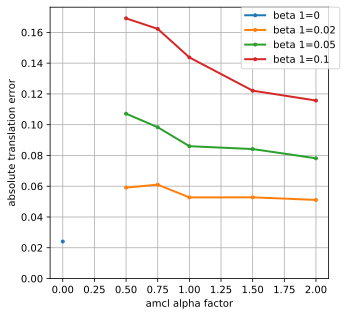

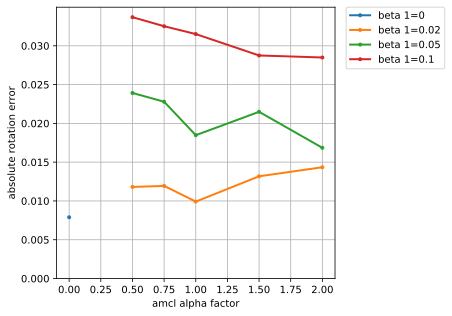

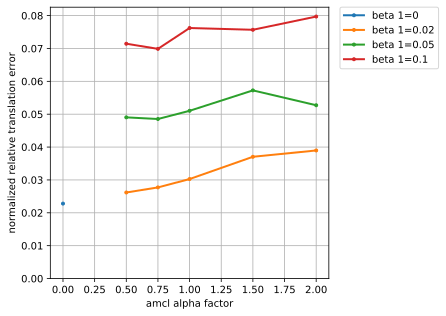

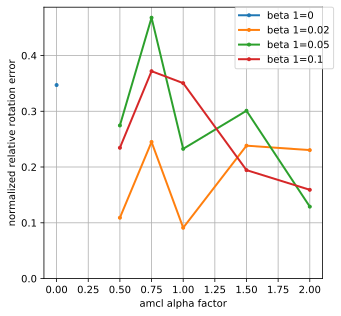

In [7]:
localization_fixed_features = [
    FeatureSelection(name='localization_node' , value='amcl', window=None, is_discrete=True),
    FeatureSelection(name='local_planner_node', value='dwb', window=None, is_discrete=True),
    FeatureSelection(name='global_planner_node', value='navfn', window=None, is_discrete=True),
    FeatureSelection(name='robot_model', value='turtle', window=None, is_discrete=True),
    FeatureSelection(name='max_steering_angle_deg', value=90.0, window=None, is_discrete=True),
]

amcl_alpha_factor_f = FeatureSelection(name='amcl_alpha_factor', value=1.0, window=None, is_discrete=True)
beta_1_f = FeatureSelection(name='beta_1', value=0.02, window=None, is_discrete=True)

localization_output = [
    'absolute_translation_error',
    'absolute_rotation_error',
    'normalized_relative_translation_error',
    'normalized_relative_rotation_error',
]

print(', '.join(map(str, localization_fixed_features)))
for output in localization_output:
    plot_predictions_2(
        d=df,
        output=output,
        feature_1=amcl_alpha_factor_f,
        feature_2=beta_1_f,
        fixed_features=localization_fixed_features,
        n1=10,
        n2=5,
        min_y=0.0,
    )

# average_translation_velocity_f = FeatureSelection(name='average_translation_velocity', value=None, window=0.02, is_discrete=False)
# average_velocity_atan_f = FeatureSelection(name='average_velocity_atan', value=None, window=0.05, is_discrete=False)

# print(', '.join(map(str, localization_fixed_features)))
# for output in localization_output:
#     plot_predictions_2(
#         d=df,
#         output=output,
#         feature_1=average_translation_velocity_f,
#         feature_2=beta_1_f,
#         fixed_features=localization_fixed_features,
#         n1=10,
#         n2=5,
#         min_y=0.0,
#     )

# print(', '.join(map(str, localization_fixed_features)))
# for output in localization_output:
#     plot_predictions_2(
#         d=df,
#         output=output,
#         feature_1=average_velocity_atan_f,
#         feature_2=beta_1_f,
#         fixed_features=localization_fixed_features,
#         n1=10,
#         n2=5,
#         min_y=0.0,
#     )


localization_node = amcl, local_planner_node = dwb, global_planner_node = navfn, robot_model = turtle, max_steering_angle_deg = 90.0


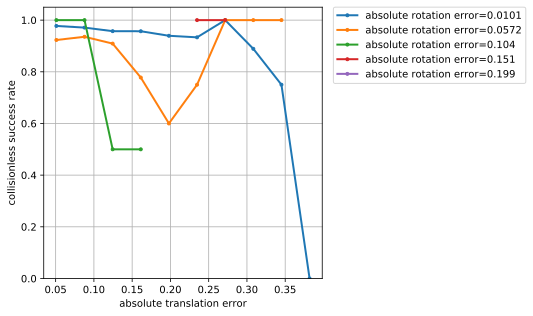

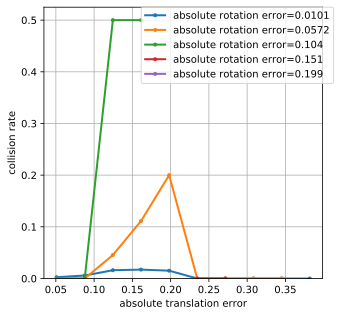

localization_node = amcl, local_planner_node = dwb, global_planner_node = navfn, robot_model = turtle, max_steering_angle_deg = 90.0


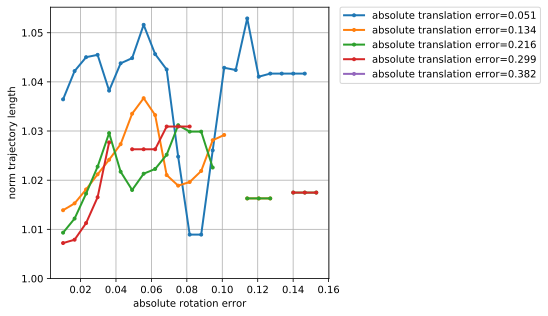

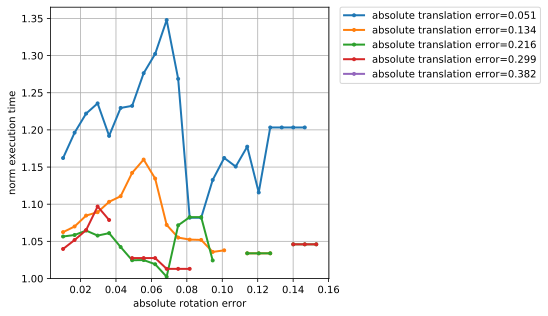

In [8]:
local_planner_fixed_features = [
    FeatureSelection(name='localization_node' , value='amcl', window=None, is_discrete=True),
    FeatureSelection(name='local_planner_node', value='dwb', window=None, is_discrete=True),
    FeatureSelection(name='global_planner_node', value='navfn', window=None, is_discrete=True),
    FeatureSelection(name='robot_model', value='turtle', window=None, is_discrete=True),
    FeatureSelection(name='max_steering_angle_deg', value=90.0, window=None, is_discrete=True),
]

absolute_translation_error_f = FeatureSelection(name='absolute_translation_error' , value=0.1, window=0.05, is_discrete=False)
absolute_rotation_error_f = FeatureSelection(name='absolute_rotation_error' , value=0.02, window=0.01, is_discrete=False)
normalized_relative_translation_error_f = FeatureSelection(name='normalized_relative_translation_error' , value=0.05, window=0.03, is_discrete=False)
normalized_relative_rotation_error_f = FeatureSelection(name='normalized_relative_rotation_error' , value=0.3, window=0.01, is_discrete=False)

# localization_performance_features = [
#     FeatureSelection(name='absolute_translation_error' , value=, window=, is_discrete=False),
#     FeatureSelection(name='absolute_rotation_error' , value=, window=, is_discrete=False),
#     FeatureSelection(name='normalized_relative_translation_error' , value=, window=, is_discrete=False),
#     FeatureSelection(name='normalized_relative_rotation_error' , value=, window=, is_discrete=False),
# ]

local_planner_output_all = [
    'collisionless_success_rate',
    'collision_rate',
]
local_planner_output_success = [
    'norm_trajectory_length',
    'norm_execution_time',
]

print(', '.join(map(str, local_planner_fixed_features)))
for output in local_planner_output_all:
    plot_predictions_2(
        d=df,
        output=output,
        feature_1=absolute_translation_error_f,
        feature_2=absolute_rotation_error_f,
        fixed_features=localization_fixed_features,
        n1=10,
        n2=5,
        min_y=0.0,
    )

print(', '.join(map(str, local_planner_fixed_features)))
for output in local_planner_output_success:
    plot_predictions_2(
        d=df,
        output=output,
        feature_1=absolute_rotation_error_f,
        feature_2=absolute_translation_error_f,
        fixed_features=localization_fixed_features + [FeatureSelection(name='collisionless_success_rate' , value=1, window=None, is_discrete=True)],
        n1=30,
        n2=5,
        min_y=1.0,
    )
